In [ ]:
#EXPERIMENT PARAMETERS

NO_CLIENTS = 10 #5, 10, 25
POISON_CLIENTS = [4,6] #Random (1,2),(1,3),(1,4)
POISON_RATIO = [1,1]
NO_ROUNDS = 7
EPOCHS_PER_ROUND = 5

#HYPERPARAMETERS

STANDARDIZE = True
CLUSTERING_ALGO = "GMM"  #GMM, KMEANS
MAYBE_POISON_ACC_RATIO = 0.8
IS_POISON_ACC_RATIO = 0.6

In [ ]:
#IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import keras
from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K
import os
from os import listdir
from PIL import Image
import pickle
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from keras.optimizers import SGD
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

In [ ]:
#LOAD CIFAR10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NO_CLASSES = 10

#INPUT PREPROCESSING

x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])

x_train  = x_train/255
x_test  = x_test/255

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

input_shape = (x_train.shape[1], x_train.shape[2], 1)

print(np.shape(x_train))
print(np.shape(x_test))

# LABEL PREPROCESSING

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train)

y_train = one_hot_encoder.transform(y_train)
y_test = one_hot_encoder.transform(y_test)

print(np.shape(y_train))
print(np.shape(y_test))

170498071/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
(50000, 32, 32, 1)
(10000, 32, 32, 1)
(50000, 10)
(10000, 10)


In [ ]:
# MODEL

class CNNModel:
    @staticmethod
    def build(input_shape, no_classes):

        model = Sequential()

        model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
        model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
        model.add(MaxPool2D((2, 2)))

        model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same'))
        model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
        model.add(MaxPool2D((2, 2)))

        model.add(Flatten())

        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))

        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(no_classes, activation='softmax'))

        return model


In [ ]:
#AVERAGE MODELS

def average_models(models):
    """
    Takes an array of identically structured keras sequential models,
    iterates layer by layer and takes weights of all layers to generate
    a new model with identical structure whose weights are the average
    of all the input models.

    Args:
        models: An array of keras sequential models with identical structure.

    Returns:
        A new keras sequential model with identical structure whose weights
        are the average of all the input models.
    """
    # Get the number of models and the number of layers in each model.
    num_models = len(models)
    num_layers = len(models[0].layers)

    # Initialize an array to hold the weights of each layer of each model.
    all_weights = np.zeros((num_models, num_layers), dtype=object)

    # Iterate over all layers of all models and collect their weights.
    for layer_idx in range(num_layers):
        layer_weights = []
        for model_idx in range(num_models):
            model = models[model_idx]
            layer = model.layers[layer_idx]
            layer_weights.append(layer.get_weights())
        all_weights[:, layer_idx] = layer_weights

    # Compute the average of all the weights for each layer.
    avg_weights = []
    for layer_idx in range(num_layers):
        layer_weights = all_weights[:, layer_idx]
        avg_layer_weights = [np.zeros_like(w) for w in layer_weights[0]]
        for w in layer_weights:
            for i in range(len(w)):
                avg_layer_weights[i] += w[i] / num_models
        avg_weights.append(avg_layer_weights)

    # Create a new model with the same structure as the input models.
    new_model = tf.keras.models.clone_model(models[0])

    # Set the weights of the new model to the computed averages.
    for layer_idx in range(num_layers):
        new_model.layers[layer_idx].set_weights(avg_weights[layer_idx])

    return new_model


In [ ]:
#SHUFFLE THE DATA RANDOMLY

data = list(zip(x_train, y_train))
shuffle(data)
client_data = np.array_split(data, NO_CLIENTS)
print(np.shape(client_data))
print(np.shape(client_data[0][0][0]))
print(np.shape(client_data[0][0][1]))

cx_train, cy_train = [],[]
for (i,data) in enumerate(client_data):
    tx,ty = [],[]
    for datapoint in data:
        tx.append(datapoint[0])
        ty.append(datapoint[1])
    cx_train.append(tx)
    cy_train.append(ty)

print(np.shape(cx_train))
print(np.shape(cy_train))

(10, 5000, 2)
(32, 32, 1)
(10,)
(10, 5000, 32, 32, 1)
(10, 5000, 10)


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [ ]:
#POISON THE DATA

for c,client in enumerate(POISON_CLIENTS):
    for i in range(int(len(cy_train[client])*POISON_RATIO[c])):
        logits = cy_train[client][i]
        poisonClass = np.random.randint(len(logits))
        poisonLogits = np.zeros(len(logits))
        poisonLogits[poisonClass] = 1
        cy_train[client][i] = poisonLogits

In [ ]:
#FEDERATED TRAINING

def train_on_client(i,global_weights,ep=EPOCHS_PER_ROUND):
    local_model = CNNModel().build(input_shape,NO_CLASSES)
    local_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    local_model.set_weights(global_weights)

    local_model.fit(np.array(cx_train[i]), np.array(cy_train[i]), epochs=ep, verbose=0)

    pred = local_model.predict(x_test, verbose = 0)
    acc = K.mean(K.equal(K.argmax(pred, axis=-1), K.argmax(y_test, axis=-1)))
    print(float(acc))

    return local_model


global_model = CNNModel().build(input_shape,NO_CLASSES)
global_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
finalRoundModels = []
final_acc = 0

for round in range(NO_ROUNDS):
    global_weights = global_model.get_weights()
    models = []

    for client in range(NO_CLIENTS):
        print('Round {} - Client {}'.format(round,client))
        client_model = train_on_client(client,global_weights)
        models.append(client_model)

    finalRoundModels = models
    global_model = average_models(models)

    pred = global_model.predict(x_test)
    acc = K.mean(K.equal(K.argmax(pred, axis=-1), K.argmax(y_test, axis=-1)))

    print("Round {}: {}% Accuracy".format(round,acc*100))
    final_acc = float(acc)

Round 0 - Client 0
0.10000000149011612
Round 0 - Client 1
0.39500001072883606
Round 0 - Client 2
0.3458999991416931
Round 0 - Client 3
0.412200003862381
Round 0 - Client 4
0.10000000149011612
Round 0 - Client 5
0.4262000024318695
Round 0 - Client 6
0.10000000149011612
Round 0 - Client 7
0.4041999876499176
Round 0 - Client 8
0.3393000066280365
Round 0 - Client 9
0.4239000082015991
313/313 [==============================] - 1s 2ms/step
Round 0: 10.0% Accuracy
Round 1 - Client 0
0.4343999922275543
Round 1 - Client 1
0.4320000112056732
Round 1 - Client 2
0.44830000400543213
Round 1 - Client 3
0.4334999918937683
Round 1 - Client 4
0.10000000149011612
Round 1 - Client 5
0.4426000118255615
Round 1 - Client 6
0.10000000149011612
Round 1 - Client 7
0.4205999970436096
Round 1 - Client 8
0.383899986743927
Round 1 - Client 9
0.4194999933242798
313/313 [==============================] - 1s 2ms/step
Round 1: 12.269999504089355% Accuracy
Round 2 - Client 0
0.49459999799728394
Round 2 - Client 1
0.501

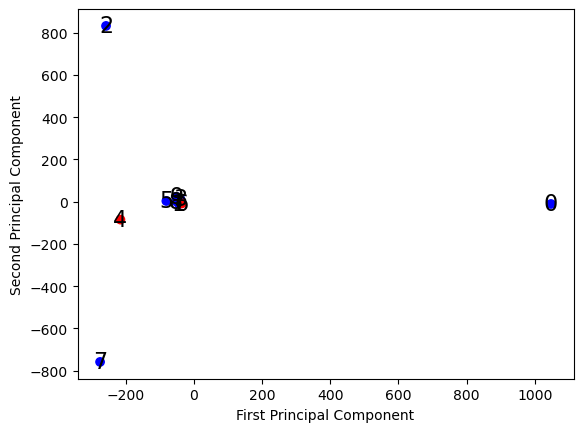

In [ ]:
#VISUALIZE MODEL WEIGHT CLUSTERS

def flatten_model(model):
    flattened_weights = np.array([])
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:
            for i in range(len(weights)):
                flattened_weights = np.concatenate((flattened_weights, np.ravel(weights[i])))
    return flattened_weights

def last_round_weights(models):
    last_round = []
    for client_model in models:
        last_round.append(flatten_model(client_model))
    return last_round

flattened = last_round_weights(finalRoundModels)
X_scaled = StandardScaler().fit_transform(flattened)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
colors = ['red' if i in POISON_CLIENTS else 'blue' for i in range(len(X_pca))]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='viridis')
for i, (x, y) in enumerate(X_pca):
    plt.annotate(i, (x, y), fontsize=16, ha='center', va='center')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()



In [ ]:
clusteringTool = KMeans(n_clusters=2)
if(CLUSTERING_ALGO=="GMM"):
    clusteringTool = GaussianMixture(2)

In [ ]:
def traceback(finalRoundModels):

    def trial(cluster):

        if(len(cluster)<1):
            return False

        temp_model = CNNModel().build(input_shape,10)
        temp_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

        models = []
        for client in cluster:
            temp_model.set_weights(finalRoundModels[client].get_weights())
            models.append(temp_model)
        temp_model = average_models(models)

        pred = temp_model.predict(x_test,verbose=0)
        acc = K.mean(K.equal(K.argmax(pred, axis=-1), K.argmax(y_test, axis=-1)))

        return float(acc)

    def recursively_cluster(cluster):

        print(cluster)

        if len(cluster) <= 1:
            return cluster

        flattened = np.array([last_round[c] for c in cluster])
        print(np.shape(flattened))

        if(STANDARDIZE):
            flattened = StandardScaler().fit_transform(flattened)
        clustering = clusteringTool.fit(flattened)
        print(clustering.labels_)

        clusterA = [cluster[i] for i in range(len(cluster)) if clustering.labels_[i]==0]
        clusterB = [cluster[i] for i in range(len(cluster)) if clustering.labels_[i]==1 or clustering.labels_[i]==-1]
        print(clusterA,clusterB)

        contains_attack_A, contains_attack_B = False,False

        trialAcc_A = trial(clusterA)
        trialAcc_B = trial(clusterB)
        print(trialAcc_A, trialAcc_B)
        faa, fab =final_acc, final_acc

        if(trialAcc_A>final_acc):
            print("Cluster A doesn't contain an attacker")
            contains_attack_A = False
            contains_attack_B = True

        if(trialAcc_B>final_acc):
            print("Cluster B doesn't contain an attacker")
            contains_attack_A = True
            contains_attack_B = False

        if(trialAcc_A<=final_acc and trialAcc_B<=final_acc):

            if len(clusterA) <= MAYBE_POISON_ACC_RATIO*NO_CLIENTS:
                faa = final_acc * (0.9 + (len(clusterA))/(10*NO_CLIENTS))
            if len(clusterB) <= MAYBE_POISON_ACC_RATIO*NO_CLIENTS:
                fab = final_acc * (0.9 + (len(clusterA))/(10*NO_CLIENTS))

            contains_attack_A = trialAcc_A <= faa
            contains_attack_B = trialAcc_B <= fab

        print(contains_attack_A,contains_attack_B)

        if contains_attack_A and contains_attack_B:
            print("Both clusters contain attackers")

            contains_attack_A = trialAcc_A <= faa*IS_POISON_ACC_RATIO
            contains_attack_B = trialAcc_B <= fab*IS_POISON_ACC_RATIO
            print(contains_attack_A,contains_attack_B)

            if contains_attack_A and contains_attack_B:
                return np.concatenate((np.array(clusterA),np.array(clusterB)))
            elif contains_attack_A:
                return np.concatenate((np.array(clusterA),np.array(recursively_cluster(clusterB))))
            elif contains_attack_B:
                return np.concatenate((np.array(clusterB),np.array(recursively_cluster(clusterA))))

        elif contains_attack_A:
            return recursively_cluster(clusterA)
        elif contains_attack_B:
            return recursively_cluster(clusterB)
        else:
            return []

    last_round = last_round_weights(finalRoundModels)
    print(np.shape(last_round))
    return recursively_cluster(np.arange(NO_CLIENTS))


In [ ]:
traceback(finalRoundModels)

(10, 1150458)
[0 1 2 3 4 5 6 7 8 9]
(10, 1150458)
